# COMP4332/RMBI4310 Project 1 - Sentiment Analysis 
### Group 26: Finalized TFIDF-BiLSTM-Numerical-MLP Model
### 2021 Spring Term, HKUST

## Section 1: Data Processing

In [1]:
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

Obtain the Data Frame with all useful columns ready (including newly derived columns)

In [2]:
def load_data(split_name):
    df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
    return df

def get_new_df(mode):
    df = load_data(mode)
    df['day_of_week'] = pd.to_datetime(df['date']).dt.weekday
    return df

train_df = get_new_df('train')
valid_df = get_new_df('valid')
test_df = get_new_df('test')

# Getting the text length of each dataframe
train_df['text_len'] = train_df['text'].apply(lambda x: len(x))
valid_df['text_len'] = valid_df['text'].apply(lambda x: len(x))
test_df['text_len'] = test_df['text'].apply(lambda x: len(x))

Correlations between the selected columns

In [3]:
corr_df = train_df.drop(columns=['cool'])
corr_df.corr().style.background_gradient(cmap='coolwarm')

,funny,stars,useful,day_of_week,text_len
funny,1.000000,-0.061346,0.507746,-0.037347,0.223274
stars,-0.061346,1.000000,-0.085296,-0.009572,-0.163387
useful,0.507746,-0.085296,1.000000,-0.037780,0.245371
day_of_week,-0.037347,-0.009572,-0.037780,1.000000,-0.027041
text_len,0.223274,-0.163387,0.245371,-0.027041,1.000000


Build the TF-IDF model

In [4]:
def lower(s):
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

def tfidf_tokenizer(text):
    tokens = nltk.word_tokenize(text) # tokenize
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    stemmed = [ps.stem(token) for token in tokens] # stem
    stems = list(map(lambda x: lower(x), stemmed)) # lower
    return stems

tfidf = TfidfVectorizer(
            tokenizer = tfidf_tokenizer, 
            ngram_range=(1,4), 
            max_features= 150000, 
            min_df= 3,
            max_df= 0.9,
        )

In [5]:
### Building the tfidf vector using training set
train_tfidf = tfidf.fit_transform(train_df['text'])

### Transform the valid set and test set using the tfidf built by training set
valid_tfidf = tfidf.transform(valid_df['text'])
test_tfidf = tfidf.transform(test_df['text'])

print(train_tfidf.shape)

(10000, 67194)


In [6]:
train_tfidf_array = train_tfidf.toarray()
valid_tfidf_array = valid_tfidf.toarray()
test_tfidf_array = test_tfidf.toarray()

print(train_tfidf_array.shape)

(10000, 67194)


Normalizing numerical feature columns all data splits

In [7]:
train_df_copy = train_df.copy()
valid_df_copy = valid_df.copy()
test_df_copy = test_df.copy()

for column in ['funny', 'useful', 'cool', 'text_len', 'day_of_week']:
    train_df_copy[column] = train_df_copy[column] /train_df_copy[column].abs().max()
    valid_df_copy[column] = valid_df_copy[column] /valid_df_copy[column].abs().max()
    test_df_copy[column] = test_df_copy[column] /test_df_copy[column].abs().max()

train_df = train_df_copy
valid_df = valid_df_copy
test_df = test_df_copy

Stack up the numeric features for all data splits

In [8]:
f = train_df['funny'].values.reshape(-1, 1)
u = train_df['useful'].values.reshape(-1, 1)
l = train_df['text_len'].values.reshape(-1, 1)
d = train_df['day_of_week'].values.reshape(-1, 1)
train_numeric = np.hstack((f,u,l,d))

f = valid_df['funny'].values.reshape(-1, 1)
u = valid_df['useful'].values.reshape(-1, 1)
l = valid_df['text_len'].values.reshape(-1, 1)
d = valid_df['day_of_week'].values.reshape(-1, 1)
valid_numeric = np.hstack((f,u,l,d))

f = test_df['funny'].values.reshape(-1, 1)
u = test_df['useful'].values.reshape(-1, 1)
l = test_df['text_len'].values.reshape(-1, 1)
d = test_df['day_of_week'].values.reshape(-1, 1)
test_numeric = np.hstack((f,u,l,d))

## Section 2: Modelling and Training

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from keras.utils import to_categorical
from keras.regularizers import l2

In [10]:
# Getting the labels
y_train = train_df['stars'].values -1
y_valid = valid_df['stars'].values -1

In [11]:
# Changing the labels to one hot vectors
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

Modelling: Bidirection LSTM of TF-IDF, concatenate, and MLP

In [12]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.BiLSTM = layers.Bidirectional(
            layers.LSTM(10, return_sequences=False, dropout=0.5, 
                        recurrent_dropout=0.5, kernel_regularizer=l2(0.005), unit_forget_bias= True,
                       ), 
            merge_mode="ave"
        )
        self.dense1 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005))
        self.dense2 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005))
        self.dense3 = Dense(5, activation='softmax')
        self.nlp_dropout = Dropout(0.3)
        self.dropout = Dropout(0.5)
        self.LN = LayerNormalization()
        self.activation = Activation('relu')
        
    def call(self, inputs):
        nlp_input = inputs[0]
        numeric_input = inputs[1]
        nlp_input = tf.reshape(tensor= nlp_input, shape=(tf.shape(nlp_input)[0], 1, tf.shape(nlp_input)[-1]))
        nlp_input = self.BiLSTM(nlp_input)
        nlp_input = self.LN(nlp_input)
        nlp_input = self.nlp_dropout(nlp_input)
        x = layers.Concatenate()([nlp_input, numeric_input])
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dense3(x)
        return x

Training the model

In [13]:
os.makedirs("models", exist_ok=True)

model = MyModel()

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=5e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models","weights.h5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

def scheduler(epoch, lr):
    if(epoch % 20 == 0 and epoch != 0):
        return lr * 0.5
    return lr

scheduler = keras.callbacks.LearningRateScheduler(
    scheduler,
    verbose=0
)

np.random.seed(0)
tf.random.set_seed(0)

history = model.fit([train_tfidf_array, train_numeric], y_train,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping, scheduler])


model.load_weights(os.path.join("models", "weights.h5"))

train_score = model.evaluate([train_tfidf_array, train_numeric], y_train,
                             batch_size=100)

test_score = model.evaluate([valid_tfidf_array, valid_numeric], y_valid,
                            batch_size=100)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

Epoch 1/100
90/90 [==============================] - 8s 41ms/step - loss: 2.2338 - accuracy: 0.1955 - val_loss: 1.9453 - val_accuracy: 0.2240
Epoch 2/100
90/90 [==============================] - 3s 32ms/step - loss: 1.9210 - accuracy: 0.2479 - val_loss: 1.8560 - val_accuracy: 0.2480
Epoch 3/100
90/90 [==============================] - 3s 31ms/step - loss: 1.8388 - accuracy: 0.2552 - val_loss: 1.7925 - val_accuracy: 0.2480
Epoch 4/100
90/90 [==============================] - 3s 33ms/step - loss: 1.7809 - accuracy: 0.2585 - val_loss: 1.7414 - val_accuracy: 0.2480
Epoch 5/100
90/90 [==============================] - 3s 31ms/step - loss: 1.7309 - accuracy: 0.2874 - val_loss: 1.6931 - val_accuracy: 0.3230
Epoch 6/100
90/90 [==============================] - 3s 31ms/step - loss: 1.6812 - accuracy: 0.3399 - val_loss: 1.6334 - val_accuracy: 0.4170
Epoch 7/100
90/90 [==============================] - 3s 31ms/step - loss: 1.6149 - accuracy: 0.4043 - val_loss: 1.5457 - val_accuracy: 0.4390
Epoch 

## Section 3: Evaluation, Output and Predictions

Plotting the loss and accuracy

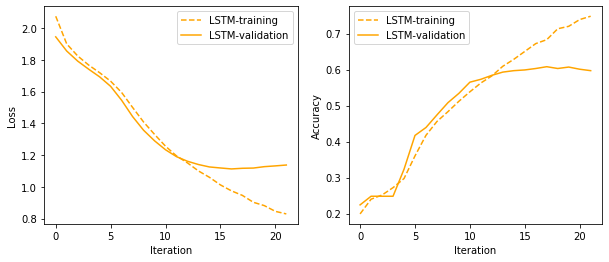

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(history.history["val_loss"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Classification Report and Confusion Matrix (with heatmap)

In [15]:
logits = model.predict([valid_tfidf_array, valid_numeric], batch_size=100)
# print(logits)
y_pred = np.argmax(logits, axis= -1)
y_true = valid_df['stars'] - 1
print(classification_report(y_true, y_pred))
conf = confusion_matrix(y_true, y_pred)
print(conf)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       517
           1       0.51      0.24      0.33       278
           2       0.49      0.53      0.51       344
           3       0.54      0.53      0.53       427
           4       0.71      0.76      0.73       434

    accuracy                           0.63      2000
   macro avg       0.60      0.59      0.58      2000
weighted avg       0.62      0.63      0.62      2000

[[453  28  22  11   3]
 [ 99  68  88  19   4]
 [ 32  33 183  80  16]
 [  9   4  74 225 115]
 [ 11   0   8  84 331]]


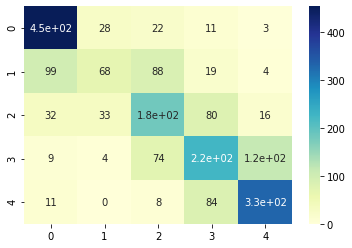

In [16]:
sns.heatmap(conf, annot=True, cmap="YlGnBu")

### Use validation set to evaluate

In [22]:
# Getting the prediction
logits = model.predict([valid_tfidf_array, valid_numeric], batch_size=100)
y_pred = np.argmax(logits, axis= -1) + 1

# Produce and export the ans and pred csv files 
val_ans = pd.DataFrame({'stars': valid_df['stars'], 'review_id': valid_df['review_id']})
val_pred = pd.DataFrame({'stars': y_pred, 'review_id': valid_df['review_id']})

output_dir = './data'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

val_ans.to_csv('./data/ans.csv', index= False)
val_pred.to_csv('./data/pred.csv', index=False)

In [23]:
%run evaluate.py

2000 2000 0
accuracy: 0.63 	precision: 0.5984055930443428 	recall: 0.5884789707174687 	f1: 0.5826348556374064


### Export test set prediction

In [25]:
# Getting the prediction
logits = model.predict([test_tfidf_array, test_numeric], batch_size=100)
y_pred = np.argmax(logits, axis= -1) + 1

# Produce and export the ans and pred csv files 
test_pred = pd.DataFrame({'stars': y_pred, 'review_id': valid_df['review_id']})
test_pred.to_csv('pre.csv', index=False)

In [ ]:
%run evaluate.py

## End of Model